In [19]:
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point

## Extra Credit - Query 7

Use NYPD Shooting Incident Data to find out the top 10 zipcode area where the shooting incidents happened the most.

### Request Shooting Incident Data

In [4]:
# API endpoint URL
url_shooting = "https://data.cityofnewyork.us/resource/833y-fsy8.json"
# Set up the headers with the API token
headers = {'X-App-Token': token}

# Make the API request
response = requests.get(url_shooting, headers=headers)
data = response.json()

# Print the data
raw_shooting= pd.DataFrame(data)
raw_shooting.head()

,incident_key,occur_date,occur_time,boro,precinct,jurisdiction_code,statistical_murder_flag,vic_age_group,vic_sex,vic_race,...,geocoded_column,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,perp_age_group,perp_sex,perp_race,location_desc
0,228798151,2021-05-27T00:00:00.000,21:30:00,QUEENS,105,0,False,18-24,M,BLACK,...,"{'type': 'Point', 'coordinates': [-73.73083868...",3,47,63,24018,63,NaN,NaN,NaN,NaN
1,137471050,2014-06-27T00:00:00.000,17:40:00,BRONX,40,0,False,18-24,M,BLACK,...,"{'type': 'Point', 'coordinates': [-73.92494232...",5,35,23,10932,49,NaN,NaN,NaN,NaN
2,147998800,2015-11-21T00:00:00.000,03:56:00,QUEENS,108,0,True,25-44,M,WHITE,...,"{'type': 'Point', 'coordinates': [-73.91549174...",3,33,66,14787,53,NaN,NaN,NaN,NaN
3,146837977,2015-10-09T00:00:00.000,18:30:00,BRONX,44,0,False,<18,M,WHITE HISPANIC,...,"{'type': 'Point', 'coordinates': [-73.91945661...",5,42,27,10930,50,NaN,NaN,NaN,NaN
4,58921844,2009-02-19T00:00:00.000,22:58:00,BRONX,47,0,True,45-64,M,BLACK,...,"{'type': 'Point', 'coordinates': [-73.85290950...",5,2,30,11275,29,25-44,M,BLACK,NaN


In [20]:
# Make a copy
df_shooting  = raw_shooting.copy()

### Clean shooting incident data

In [21]:
def shoot_cleaning(df=df_shooting) -> gpd.GeoDataFrame:
    """
    Clean the raw data

    Argument:
        df(pd.DataFrame): raw data of shooting incidents

    Returns:
        gpd.GeoDataFrame
    """

   # Drop unnecessary columns
    df_2 = df.loc[:, ['occur_date', 'longitude', 'latitude']]

    # Drop rows with null values
    df_3 = df_2.dropna()

    # Normalize the name of date column
    df_3.rename(columns={'occur_date': 'date'}, inplace=True)

    # Transform date columns from strings to datetime Python objects
    df_3['date'] = pd.to_datetime(df_3['date'])

    # Normalize the Spatial Reference Identifiers (SRID) of any geometry.
    df_3['location'] = [Point(xy) for xy in zip(df_3.longitude, df_3.latitude)]
    gdf = gpd.GeoDataFrame(df_3, geometry='location')
    gdf.crs = 'EPSG:4326'

    return gdf


In [24]:
# Data cleaning
gdf_shooting = shoot_cleaning()

# Display the first 5 rows in the dataframe
gdf_shooting.head()

,date,longitude,latitude,location
0,2021-05-27,-73.73083868899994,40.662964620000025,POINT (-73.73084 40.66296)
1,2014-06-27,-73.924942325999950,40.810351863000051,POINT (-73.92494 40.81035)
2,2015-11-21,-73.915491741999972,40.742606633000037,POINT (-73.91549 40.74261)
3,2015-10-09,-73.919456614999945,40.837782003000029,POINT (-73.91946 40.83778)
4,2009-02-19,-73.852909508999971,40.886237918000063,POINT (-73.85291 40.88624)


In [30]:
sql_shooting = to_schema(gdf_shooting, 'shooting', geometry='geometry(POINT,4326)')

/var/folders/78/mzvhkg9541qgk1th67dnww8m0000gn/T/ipykernel_29543/1343850453.py:27: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, dtype in dtypes.iteritems():


In [33]:
gdf_shooting.to_postgis("shooting", engine, if_exists='append', index=True, index_label='id')

Join both zipcodes and shooting table where the coordinate point of the shooting incident is inside the polygon boundary of the zipcode as defined in the zipcode table.

In [51]:
query_7 = """
SELECT zipcodes.zipcode, COUNT(*) AS shooting_count
FROM shooting
JOIN zipcodes ON ST_Within(shooting.location, zipcodes.location)
GROUP BY zipcodes.zipcode
ORDER BY shooting_count DESC
LIMIT 10
"""

# Execute the query
result_df_7 = execute_query(query_7, "Query 7")


In [55]:
result_df_7

,zipcode,shooting_count
0,11212,46
1,11207,44
2,11233,38
3,11221,30
4,11208,27
5,11226,25
6,10457,24
7,10456,23
8,11203,22
9,11206,21


# Data Preprocessing

### Read data

In [37]:
token = "vAtl2Z7zE587vSL1K0jPGUqgw"

Download zipcode data

In [38]:
raw_zipcode = gpd.read_file("nyc_zipcodes.shp")
raw_zipcode

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((950767.507 172848.969, 950787.510 17..."
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995877.318 203206.075, 995968.511 20..."
261,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((997731.761 219560.922, 997641.948 21..."


Download zillow data

In [4]:
raw_zillow = pd.read_csv("zillow_rent_data.csv")
raw_zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2015-01-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,1606.206406,...,1994.653463,2027.438438,2042.237444,2049.325559,2016.531345,2023.438976,2031.558202,2046.144009,2053.486247,2055.771355
1,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,1257.814660,...,1749.697900,1738.217986,1747.305840,1758.407295,1758.891075,1762.980879,1771.751591,1779.338402,1795.384582,1799.631140
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,NaN,...,1701.217520,1706.900064,1706.067787,1723.722320,1735.484670,1752.132904,1756.990323,1754.429516,1757.602011,1755.031490
3,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,NaN,...,1419.480272,1458.063897,1471.726681,1466.734658,1456.175660,1462.478506,1466.267391,1490.237063,1488.180414,1494.366097
4,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783


Download 311 data with API

In [5]:
# API endpoint URL
url_311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date between \'2015-01-01\' and \'2023-10-01\'&$limit=10000000000&$SELECT=created_date,complaint_type,incident_zip,latitude,longitude'

# Set up the headers with the API token
headers = {'X-App-Token': token}

# Make the API request
response = requests.get(url_311, headers=headers)
data = response.json()

# Print the data
raw_311= pd.DataFrame(data)
raw_311

,created_date,complaint_type,incident_zip,latitude,longitude
0,2023-09-30T23:59:58.000,Noise - Street/Sidewalk,11226,40.655672001198894,-73.95917686020623
1,2023-09-30T23:59:38.000,Noise - Residential,11361,40.76675595839554,-73.78751847563191
2,2023-09-30T23:59:35.000,Noise - Commercial,10002,40.71949965458691,-73.98486650733275
3,2023-09-30T23:59:34.000,Noise - Residential,11435,40.687499303408536,-73.7972903094197
4,2023-09-30T23:59:28.000,Noise - Residential,11226,40.65220215349917,-73.9579464603267
...,...,...,...,...,...
24336514,2015-01-01T00:00:00.000,HEAT/HOT WATER,10028,40.776440176160676,-73.95570886749827
24336515,2015-01-01T00:00:00.000,HEAT/HOT WATER,10037,40.81306232619066,-73.9416351748284
24336516,2015-01-01T00:00:00.000,PAINT/PLASTER,10034,40.86836642930603,-73.9164221678853
24336517,2015-01-01T00:00:00.000,HEAT/HOT WATER,10459,40.824342895821275,-73.89188968213699


Download tree data with API

In [6]:
# API endpoint URL
url_tree = 'https://data.cityofnewyork.us/resource/5rq2-4hqu.json?$limit=10000000000'

# Set up the headers with the API token
headers = {'X-App-Token': token}

# Make the API request
response = requests.get(url_tree, headers=headers)
data = response.json()

# Print the data
raw_tree = pd.DataFrame(data)
raw_tree.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,"{'type': 'Point', 'coordinates': [-73.84421521...",3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.72309177,-73.84421522,1027431.14821,202756.768749
1,09/03/2015,200540,315986,"{'type': 'Point', 'coordinates': [-73.81867945...",21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.79411067,-73.81867946,1034455.70109,228644.837379
2,09/05/2015,204026,218365,"{'type': 'Point', 'coordinates': [-73.93660770...",3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.71758074,-73.9366077,1001822.83131,200716.891267
3,09/05/2015,204337,217969,"{'type': 'Point', 'coordinates': [-73.93445615...",10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.71353749,-73.93445616,1002420.35833,199244.253136
4,08/30/2015,189565,223043,"{'type': 'Point', 'coordinates': [-73.97597938...",21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.66677776,-73.97597938,990913.775046,182202.425999


### Removing unnecessary columns

In [39]:
columns_to_drop = raw_zipcode.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
gdf_zipcode_1 = raw_zipcode.drop(columns=columns_to_drop)
gdf_zipcode_1.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [8]:
df_zillow_1 = pd.concat([raw_zillow.iloc[:, [2, 6]], raw_zillow.iloc[:, 9:]], axis=1)
df_zillow_1.head()

,RegionName,City,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,77494,Katy,1606.206406,1612.779844,1622.201575,1630.392427,1632.411500,1636.206864,1644.894632,1643.390762,...,1994.653463,2027.438438,2042.237444,2049.325559,2016.531345,2023.438976,2031.558202,2046.144009,2053.486247,2055.771355
1,77449,Katy,1257.814660,1255.268025,1262.170452,1274.955754,1285.526052,1295.665673,1296.650395,1300.868081,...,1749.697900,1738.217986,1747.305840,1758.407295,1758.891075,1762.980879,1771.751591,1779.338402,1795.384582,1799.631140
2,77084,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1701.217520,1706.900064,1706.067787,1723.722320,1735.484670,1752.132904,1756.990323,1754.429516,1757.602011,1755.031490
3,79936,El Paso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1419.480272,1458.063897,1471.726681,1466.734658,1456.175660,1462.478506,1466.267391,1490.237063,1488.180414,1494.366097
4,11385,New York,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,2264.966715,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783


In [9]:
df_311_1 = raw_311.loc[:, ['created_date', 'complaint_type', 'incident_zip', "latitude", "longitude"]]
df_311_1.head()

,created_date,complaint_type,incident_zip,latitude,longitude
0,2023-09-30T23:59:58.000,Noise - Street/Sidewalk,11226,40.655672001198894,-73.95917686020623
1,2023-09-30T23:59:38.000,Noise - Residential,11361,40.76675595839554,-73.78751847563191
2,2023-09-30T23:59:35.000,Noise - Commercial,10002,40.71949965458691,-73.98486650733275
3,2023-09-30T23:59:34.000,Noise - Residential,11435,40.687499303408536,-73.7972903094197
4,2023-09-30T23:59:28.000,Noise - Residential,11226,40.65220215349917,-73.9579464603267


In [10]:
df_tree_1 = raw_tree.loc[:, ["zipcode", "tree_id", "latitude", "longitude", "x_sp", "y_sp", "status", "health", "spc_common"]]
df_tree_1.head()

,zipcode,tree_id,latitude,longitude,x_sp,y_sp,status,health,spc_common
0,11375,180683,40.72309177,-73.84421522,1027431.14821,202756.768749,Alive,Fair,red maple
1,11357,200540,40.79411067,-73.81867946,1034455.70109,228644.837379,Alive,Fair,pin oak
2,11211,204026,40.71758074,-73.9366077,1001822.83131,200716.891267,Alive,Good,honeylocust
3,11211,204337,40.71353749,-73.93445616,1002420.35833,199244.253136,Alive,Good,honeylocust
4,11215,189565,40.66677776,-73.97597938,990913.775046,182202.425999,Alive,Good,American linden


### Remove invalid data points 

Drop duplication

In [40]:
gdf_zipcode_2 = gdf_zipcode_1.drop_duplicates().reset_index(drop=True)
gdf_zipcode_2.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


Drop the rows in df_zillow outsied NYC

In [12]:
index = df_zillow_1[df_zillow_1['City'] != "New York"].index
df_zillow_2 = df_zillow_1.drop(index).reset_index(drop=True)
df_zillow_2 = df_zillow_2.drop(["City"], axis=1)
df_zillow_2.head()

,RegionName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,11385,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,2264.966715,2297.900917,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783
1,11208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2508.670432,2588.030194,2613.790654,2585.561351,2633.200754,2672.038493,2806.918757,2765.224364,2737.547470,2728.733333
2,11236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.460026,2362.500000
3,10467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2145.642295,2155.617718,2172.346611,2160.962748,2110.533203,2180.323655,2276.372290,2334.204728,2353.686402,2423.888889
4,11373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2199.459063,2255.604528,2262.101623,2271.514956,2250.182334,2231.959479,2257.413993,2247.592851,2302.557354,2292.994444


Change the format of rent dataframe

In [13]:
df_rent_1 = pd.DataFrame(columns=["zipcode", "date", "rent"])
temp_data = []
for index, row in df_zillow_2.iterrows():
    for i in range(len(row)-1):
        temp_data.append({"zipcode": str(int(row[0])), "date": df_zillow_2.columns[i+1], "rent": row[i+1]})
df_rent_1 = pd.concat([df_rent_1, pd.DataFrame(temp_data)], ignore_index=True)
df_rent_1.dropna(subset=['rent'], inplace=True)
df_rent_1 = df_rent_1.reset_index(drop=True)
df_rent_1

,zipcode,date,rent
0,11385,2015-02-28,2087.527084
1,11385,2015-04-30,2149.924252
2,11385,2015-05-31,2166.263698
3,11385,2015-06-30,2148.992886
4,11385,2015-07-31,2190.098591
...,...,...,...
9034,10004,2023-05-31,4240.040733
9035,10004,2023-06-30,4286.776061
9036,10004,2023-07-31,4270.158740
9037,10004,2023-08-31,4353.055657


Drop all rows in df_tree and df_311 with null values.

In [14]:
df_311_1 = df_311_1.dropna()
df_tree_1 = df_tree_1.dropna()

### Normalize column names & column types where needed

Normalize the name of zipcode colunms

In [15]:
df_311_1.rename(columns={'incident_zip': 'zipcode', 'created_date': 'date'}, inplace=True)
df_311_1.head()

,date,complaint_type,zipcode,latitude,longitude
0,2023-09-30T23:59:58.000,Noise - Street/Sidewalk,11226,40.655672001198894,-73.95917686020623
1,2023-09-30T23:59:38.000,Noise - Residential,11361,40.76675595839554,-73.78751847563191
2,2023-09-30T23:59:35.000,Noise - Commercial,10002,40.71949965458691,-73.98486650733275
3,2023-09-30T23:59:34.000,Noise - Residential,11435,40.687499303408536,-73.7972903094197
4,2023-09-30T23:59:28.000,Noise - Residential,11226,40.65220215349917,-73.9579464603267


In [41]:
gdf_zipcode_2.rename(columns={'ZIPCODE': 'zipcode', 'geometry': 'location'}, inplace=True)
gdf_zipcode_2 = gdf_zipcode_2.set_geometry('location')
gdf_zipcode_2.head()

,zipcode,location
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [17]:
df_tree_1.rename(columns={'spc_common': 'species'}, inplace=True)
df_tree_1.head()

,zipcode,tree_id,latitude,longitude,x_sp,y_sp,status,health,species
0,11375,180683,40.72309177,-73.84421522,1027431.14821,202756.768749,Alive,Fair,red maple
1,11357,200540,40.79411067,-73.81867946,1034455.70109,228644.837379,Alive,Fair,pin oak
2,11211,204026,40.71758074,-73.9366077,1001822.83131,200716.891267,Alive,Good,honeylocust
3,11211,204337,40.71353749,-73.93445616,1002420.35833,199244.253136,Alive,Good,honeylocust
4,11215,189565,40.66677776,-73.97597938,990913.775046,182202.425999,Alive,Good,American linden


Transform date columns from strings to datetime Python objects


In [18]:
# Transform date columns from strings to datetime Python objects
df_311_1['date'] = pd.to_datetime(df_311_1['date'])
print(df_311_1.dtypes) 

date              datetime64[ns]
complaint_type            object
zipcode                   object
latitude                  object
longitude                 object
dtype: object


In [19]:
df_rent_1['date'] = pd.to_datetime(df_rent_1['date'])
print(df_rent_1.dtypes) 

zipcode            object
date       datetime64[ns]
rent              float64
dtype: object


### Normalize the Spatial Reference Identifiers (SRID) of any geometry.

In [20]:
from shapely.geometry import Point

In [42]:
gdf_zipcode_2 = gdf_zipcode_2.to_crs('EPSG:4326')
gdf_zipcode_2.head()

,zipcode,location
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [22]:
print(gdf_zipcode_2.crs)

EPSG:4326


In [49]:
# Normalize the Spatial Reference Identifiers (SRID) of any geometry.
df_tree_1['location'] = [Point(xy) for xy in zip(df_tree_1.longitude, df_tree_1.latitude)]
gdf_tree_1 = gpd.GeoDataFrame(df_tree_1, geometry='location')
gdf_tree_1.crs = 'EPSG:4326'
gdf_tree_1

,zipcode,tree_id,latitude,longitude,x_sp,y_sp,status,health,species,location
0,11375,180683,40.72309177,-73.84421522,1027431.14821,202756.768749,Alive,Fair,red maple,POINT (-73.84422 40.72309)
1,11357,200540,40.79411067,-73.81867946,1034455.70109,228644.837379,Alive,Fair,pin oak,POINT (-73.81868 40.79411)
2,11211,204026,40.71758074,-73.9366077,1001822.83131,200716.891267,Alive,Good,honeylocust,POINT (-73.93661 40.71758)
3,11211,204337,40.71353749,-73.93445616,1002420.35833,199244.253136,Alive,Good,honeylocust,POINT (-73.93446 40.71354)
4,11215,189565,40.66677776,-73.97597938,990913.775046,182202.425999,Alive,Good,American linden,POINT (-73.97598 40.66678)
...,...,...,...,...,...,...,...,...,...,...
683783,11211,155433,40.71321078,-73.95494401,996740.685965,199121.636255,Alive,Good,pin oak,POINT (-73.95494 40.71321)
683784,11375,183795,40.71519444,-73.8566502,1023989.07438,199873.647547,Alive,Good,Kentucky yellowwood,POINT (-73.85665 40.71519)
683785,10314,166161,40.62076153,-74.13651724,946351.410431,165466.07627,Alive,Good,red maple,POINT (-74.13652 40.62076)
683786,10457,184028,40.85082819,-73.90311472,1011053.64553,249271.950653,Alive,Good,red maple,POINT (-73.90311 40.85083)


In [24]:
df_311_1['location'] = [Point(xy) for xy in zip(df_311_1.longitude, df_311_1.latitude)]
gdf_311_1 = gpd.GeoDataFrame(df_311_1, geometry='location')
gdf_311_1.crs = 'EPSG:4326'
gdf_311_1.head()

,date,complaint_type,zipcode,latitude,longitude,location
0,2023-09-30 23:59:58,Noise - Street/Sidewalk,11226,40.655672001198894,-73.95917686020623,POINT (-73.95918 40.65567)
1,2023-09-30 23:59:38,Noise - Residential,11361,40.76675595839554,-73.78751847563191,POINT (-73.78752 40.76676)
2,2023-09-30 23:59:35,Noise - Commercial,10002,40.71949965458691,-73.98486650733275,POINT (-73.98487 40.71950)
3,2023-09-30 23:59:34,Noise - Residential,11435,40.687499303408536,-73.7972903094197,POINT (-73.79729 40.68750)
4,2023-09-30 23:59:28,Noise - Residential,11226,40.65220215349917,-73.9579464603267,POINT (-73.95795 40.65220)


# Storing Data

## Create database

In [43]:
import subprocess

def setup_new_postgis_database(db_name):
    """
    Set up a new PostGIS database.

    Arguments:
        db_name (str): The name of the new database.

    Returns:
        None
    """
    # Create the database
    subprocess.run(['createdb', db_name])

    # Enable the PostGIS extension
    subprocess.run(['psql', '--dbname', db_name, '-c', 'CREATE EXTENSION postgis;'])

In [27]:
# Set up the new PostGIS database
setup_new_postgis_database('group36project')

createdb: error: database creation failed: ERROR:  database "group36project" already exists
ERROR:  extension "postgis" already exists


## Create a schema.sql file that defines each table’s schema.

In [44]:
from sqlalchemy import create_engine
from geoalchemy2 import Geometry, WKTElement
# Connect to the database and enable the PostGIS extension
engine = create_engine('postgresql:///group36project')
conn = engine.connect()
conn.execute("CREATE EXTENSION IF NOT EXISTS postgis;")

In [45]:
def to_schema(df, table_name, geometry='geometry(GEOMETRY,4326)') -> str:
    """
    Generate a schema.sql file based on a DataFrame.

    Arrguments:
        df (pandas.DataFrame): The DataFrame containing the data.
        table_name (str): The name of the table.
        geometry (str, optional): The geometry column type. Defaults to 'geometry(GEOMETRY,4326)'.

    Returns:
        str: The CREATE TABLE statement for the schema.sql file.
    """
    # Get the data types of each column
    dtypes = df.dtypes

    # Create a mapping from pandas data types to SQL data types
    type_mapping = {
        'int64': 'INTEGER',
        'float64': 'REAL',
        'datetime64[ns]': 'TIMESTAMP',
        'object': 'TEXT',
        'geometry': geometry 
    }

    # Generate SQL definitions for each column
    definitions = []
    for column, dtype in dtypes.iteritems():
        sql_type = type_mapping[str(dtype)]
        definitions.append(f'    {column} {sql_type}')
    
    # Generate and return the full CREATE TABLE statement
    return f'CREATE TABLE IF NOT EXISTS {table_name} (\n    id INTEGER PRIMARY KEY,\n' + ',\n'.join(definitions) + '\n);'

In [46]:
# Using dataframes to create schema.sql files
sql_zipcode = to_schema(gdf_zipcode_2, 'zipcodes', geometry='geometry(POLYGON,4326)')
sql_311 = to_schema(gdf_311_1, 'complaints', geometry='geometry(POINT,4326)')
sql_tree = to_schema(gdf_tree_1, 'trees', geometry='geometry(POINT,4326)')
sql_zillow = to_schema(df_rent_1, 'rents')

/var/folders/78/mzvhkg9541qgk1th67dnww8m0000gn/T/ipykernel_29543/1343850453.py:27: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, dtype in dtypes.iteritems():


In [48]:
# Write to 'schema.sql' file
with open('schema.sql', 'w') as f:
    f.write(sql_zipcode)
    f.write(sql_311)
    f.write(sql_tree)
    f.write(sql_zillow)

In [49]:
with open('schema.sql') as f:
    with engine.connect() as connection:
        connection.execute(f.read())

In [31]:
# Write to 'schema.sql' file
with open('schema.sql', 'a') as f:
    f.write(sql_shooting)

In [32]:
with open('schema.sql') as f:
    with engine.connect() as connection:
        connection.execute(f.read())

## Add data to database

In [161]:
gdf_311_1.to_postgis("complaints", engine, if_exists='append', index=True, index_label='id')
gdf_tree_1.to_postgis("trees", engine, if_exists='append', index=True, index_label='id')
df_rent_1.to_sql("rents", engine, if_exists='append', index=True, index_label='id')
gdf_zipcode_2.to_postgis("zipcodes", engine, if_exists='append', index=True, index_label='id')


# Understanding Data

In [34]:
from sqlalchemy import text

# Define a function to write query to a file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as f:
        f.write(query)

In [35]:
def write_query_to_file(query, outfile):
    """
    Write a SQL query to a file.

    Arguments:
        query (str): The SQL query statement.
        outfile (str): The path of the output file.

    Returns:
        None
    """
    with open(outfile, 'w') as f:
        f.write(query)

In [36]:
def execute_query(query, filename) -> pd.DataFrame:
    """
    Execute the query to get required data from the database, write it to a file, and return a DataFrame.

    Arguments:
        query (str): The query statement.
        filename (str): The name of the query file.

    Returns:
        pd.DataFrame: DataFrame with the required data.
    """
    # Execute the query and fetch the results into a pandas DataFrame
    df = pd.read_sql_query(query, engine)

    # Execute the query using the connection from the engine
    with engine.connect() as conn:
        conn.execute(text(query))

    # Write the query to a file
    write_query_to_file(query, filename)

    # Display the DataFrame
    return df

### Query 1

In [165]:
# Define SQL query
query_1 = """
SELECT zipcode, COUNT(*) AS complaints_count
FROM complaints
WHERE date BETWEEN '2022-10-01' AND '2023-10-01'
GROUP BY zipcode
ORDER BY complaints_count DESC;
"""

# Execute the query
result_df_1 = execute_query(query_1, "Query 1")

In [166]:
result_df_1.head()

,zipcode,complaints_count
0,11226,49283
1,10467,47364
2,10468,44046
3,10452,43858
4,11385,43588


### Query 2

In [168]:
# Define SQL query
query_2 = """
SELECT zipcode, COUNT(*) AS trees_count
FROM trees
GROUP BY zipcode
ORDER BY trees_count DESC
LIMIT 10;
"""

# Execute the query
result_df_2 = execute_query(query_2, "Query 2")

In [169]:
result_df_2.head()

,zipcode,trees_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838


### Query3

In [170]:
# Define SQL query
query_3 = """
SELECT trees_count.zipcode, TO_CHAR(rents.rent, 'FM9,999,999,999.99') AS average_rent
FROM (
    SELECT zipcode, COUNT(*) AS trees_count
    FROM trees
    GROUP BY zipcode
    ORDER BY trees_count DESC
    LIMIT 10
) AS trees_count
JOIN rents ON trees_count.zipcode = rents.zipcode
WHERE rents.date = '2023-08-31'
ORDER BY trees_count.trees_count DESC;
"""

# Execute the query
result_df_3 = execute_query(query_3, "Query 3")

In [171]:
result_df_3.head()

,zipcode,average_rent
0,10312,"1,775.09"
1,10314,"2,465.47"
2,10306,"2,331.54"
3,10309,"1,832.01"
4,11234,"2,312.31"


### Query4

In [172]:
# Define SQL query
query_4 = """
(SELECT h_rent.zipcode, h_rent.rent, trees_count.trees_count, complaints_count.complaints_count 
FROM (
    SELECT zipcode, TO_CHAR(rents.rent, 'FM9,999,999,999.99') AS rent 
    FROM rents
    WHERE date = '2023-01-31'
    ORDER BY rent DESC
    LIMIT 5
) AS h_rent
JOIN  (
    SELECT zipcode, COUNT(*) AS trees_count
    FROM trees
    GROUP BY zipcode
) AS trees_count ON h_rent.zipcode = trees_count.zipcode
JOIN (
    SELECT zipcode, COUNT(*) AS complaints_count
    FROM complaints
    WHERE date BETWEEN '2023-01-01' AND '2023-02-01'
    GROUP BY zipcode
) AS complaints_count ON h_rent.zipcode = complaints_count.zipcode)
UNION ALL
(SELECT l_rent.zipcode, l_rent.rent, trees_count.trees_count, complaints_count.complaints_count 
FROM (
    SELECT zipcode, TO_CHAR(rents.rent, 'FM9,999,999,999.99') AS rent 
    FROM rents
    WHERE date = '2023-01-31'
    ORDER BY rent ASC
    LIMIT 5
) AS l_rent
JOIN  (
    SELECT zipcode, COUNT(*) AS trees_count
    FROM trees
    GROUP BY zipcode
) AS trees_count ON l_rent.zipcode = trees_count.zipcode
JOIN (
    SELECT zipcode, COUNT(*) AS complaints_count
    FROM complaints
    WHERE date BETWEEN '2023-01-01' AND '2023-02-01'
    GROUP BY zipcode
) AS complaints_count ON l_rent.zipcode = complaints_count.zipcode)
"""

# Execute the query
result_df_4 = execute_query(query_4, "Query 4")

In [173]:
result_df_4.head()

,zipcode,rent,trees_count,complaints_count
0,10007,"7,270.24",338,232
1,10011,"4,741.87",2040,1508
2,10013,"5,480.11",1132,762
3,10069,"4,959.67",112,36
4,10282,"7,143.35",230,42


### Query5

In [174]:
# Define SQL query
query_5 = """
SELECT zipcodes.zipcode, COUNT(*) AS trees_count
FROM trees
JOIN zipcodes ON ST_Within(trees.location, zipcodes.location)
GROUP BY zipcodes.zipcode
ORDER BY trees_count DESC
LIMIT 10
"""

# Execute the query
result_df_5 = execute_query(query_5, "Query 5")



In [175]:
result_df_5.head()

,zipcode,trees_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838


### Query6

In [176]:
# Get target point
target_point = "POINT(-73.96253174434912 40.80737875669467)"

# Define SQL query
query_6 = f"""
SELECT tree_id AS id, species, health, status, ST_AsText(location) AS location 
FROM trees 
WHERE ST_DWithin(ST_Transform(location, 4326)::geography, ST_GeomFromText('{target_point}', 4326)::geography, 804.672);
"""

# Execute the query
result_df_6 = execute_query(query_6, "Query 6")

In [177]:
result_df_6

,id,species,health,status,location
0,198514,pin oak,Good,Alive,POINT(-73.9620798 40.80230109)
1,209919,London planetree,Good,Alive,POINT(-73.96331506 40.80881155)
2,209921,London planetree,Good,Alive,POINT(-73.96340334 40.80874458)
3,203887,willow oak,Good,Alive,POINT(-73.96071917 40.80572583)
4,196440,American elm,Fair,Alive,POINT(-73.96412322 40.81114538)
...,...,...,...,...,...
2767,189186,ginkgo,Poor,Alive,POINT(-73.95820478 40.80808229)
2768,198513,northern red oak,Good,Alive,POINT(-73.96219168 40.80234813)
2769,203888,Japanese zelkova,Fair,Alive,POINT(-73.96115906 40.80590977)
2770,198508,pin oak,Good,Alive,POINT(-73.96290465 40.80264795)


# Visualizing Data

In [188]:
import pandas as pd

def get_data(query) -> pd.DataFrame:
    """
    Execute the query to get the required data from the database and read the data into a DataFrame.

    Arguments:
        query (str): The SQL query statement.

    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """
    # Execute the query and fetch the results into a pandas DataFrame
    df = pd.read_sql_query(query, engine)

    # Return the DataFrame
    return df

## Visualization 1

Here we choose line chart, because it can clearly show the trends and changes of the numbers of all top 3 complaint types for October 1st, 2022 to September 30th, 2023.

In [207]:
# Define SQL query
query_visual_1 = """
WITH TopComplaintTypes AS (
    SELECT complaint_type, COUNT(*) AS complaint_count
    FROM complaints
    WHERE date BETWEEN '2022-10-01' AND '2023-10-01'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 3
)
SELECT DATE_TRUNC('day', date::timestamp) AS truncated_date,
       complaint_type,
       COUNT(*) AS complaint_count
FROM complaints
WHERE complaint_type IN (SELECT complaint_type FROM TopComplaintTypes)
      AND date BETWEEN '2022-10-01' AND '2023-10-01'
GROUP BY truncated_date, complaint_type
ORDER BY truncated_date, complaint_count DESC;
"""

# Get data
df_visual_1 = get_data(query_visual_1)

In [208]:
# Display the first 5 rows in the dataframe
df_visual_1.head()

,truncated_date,complaint_type,complaint_count
0,2022-10-01,Noise - Residential,1152
1,2022-10-01,Illegal Parking,986
2,2022-10-01,HEAT/HOT WATER,498
3,2022-10-02,Noise - Residential,1051
4,2022-10-02,Illegal Parking,984


In [195]:
def get_top_3_complaint_type(data=df_visual_1) -> str:
    """
    Get the top 3 complaint types based on df_visual_1.

    Arguments:
        data (pandas.DataFrame): DataFrame containing the complaint data.

    Returns:
        str: String containing the top 3 complaint types.
    """
    types = data["complaint_type"].unique()
    return f"Top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive) are: {types[0]}, {types[1]}, {types[2]}"

In [196]:
# Display the top 3 complaint types
Get_Top_3_Complaint_Type()

'Top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive) are: Noise - Residential, Illegal Parking, HEAT/HOT WATER'

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation


In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualization_1(df=df_visual_1) -> None:
    """
    Use line plot to visualize the data of top 3 complaint types.

    Argument:
        df: data of top 3 complaint types

    Return: 
        None
    """
    df['truncated_date'] = pd.to_datetime(df['truncated_date'])

    # Create a line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='truncated_date', y='complaint_count', hue='complaint_type', data=df)
    
    # Set axis labels and title
    plt.title('Number of Complaints per Day for Top Complaint Types')
    plt.xlabel('Date')
    plt.ylabel('Complaint Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Display the plot
    plt.show()

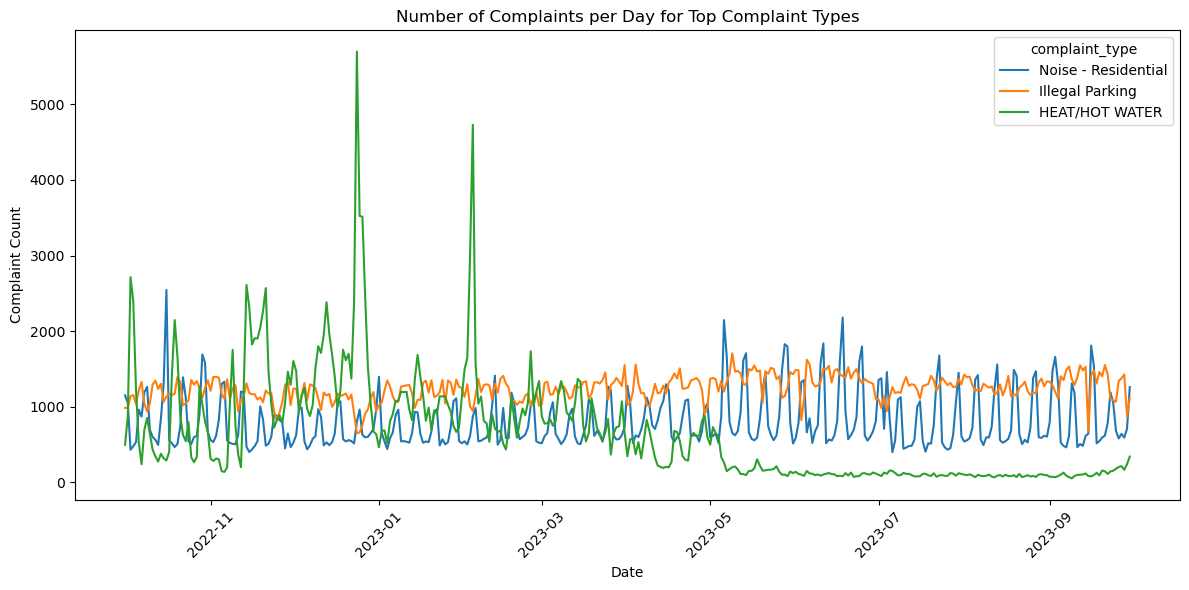

In [199]:
# Use line plot to visualize the data of top 3 complaint types.
visualization_1()

## Visualization 2

Here we use a animated bar plot, because it makes it easy to compare the values of different complaint types.

In [200]:
query_visual_2 = """
SELECT complaint_type, COUNT(*) AS complaints_count
FROM complaints
WHERE date BETWEEN '2018-10-01' AND '2023-10-01' AND zipcode = '10027'
GROUP BY complaint_type
ORDER BY complaints_count DESC
LIMIT 10
"""

# Get data
df_visual_2 = get_data(query_visual_2)

,complaint_type,complaints_count
0,Noise - Residential,19689
1,HEAT/HOT WATER,13357
2,Noise - Street/Sidewalk,10892
3,Illegal Parking,8033
4,UNSANITARY CONDITION,4272
5,Request Large Bulky Item Collection,3938
6,PLUMBING,3105
7,Rodent,2692
8,PAINT/PLASTER,2574
9,Noise,2543


In [209]:
# Display the first 5 rows in the dataframe
df_visual_2.head()

,complaint_type,complaints_count
0,Noise - Residential,19689
1,HEAT/HOT WATER,13357
2,Noise - Street/Sidewalk,10892
3,Illegal Parking,8033
4,UNSANITARY CONDITION,4272


In [210]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def visualization_2(df=df_visual_2) -> animation.FuncAnimation:
    """
    Use animated bar plot to visualize the data of top 10 complaint types in zip code 10027 for October 1st, 2018 to September 30th, 2023.

    Arguments:
        df (DataFrame): Data of Number of Complaints per Day for Top Complaint Types

    Returns:
        animation.FuncAnimation: Animated Bar Plot of Number of Complaints per Day for Top Complaint Types
    """

    # Set the size
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set bar plot
    bars = ax.bar(df['complaint_type'], df['complaints_count'], color="blue")

    # Set labels and title
    ax.set_xlabel('Complaint Type')
    ax.set_ylabel('Count')
    ax.set_xticklabels(df['complaint_type'], rotation=45, ha='right')
    ax.set_title('Number of Complaints by Type')

    # Define the animation function
    def animate(i) -> list:
        """
        Update the heights of the bars for a given animation frame.

        Arguments:
            i (int): Animation frame index.

        Returns:
            animation.Artist: Updated bar heights.
        """
        for j in range(len(bars)):
            count = df['complaints_count'].iloc[j]
            bars[j].set_height(count * (i + 1) / len(df))
        return bars

    # Create the animation
    anim = animation.FuncAnimation(fig, animate, frames=len(df), interval=200, blit=True)

    # Display the animation
    return anim

/var/folders/78/mzvhkg9541qgk1th67dnww8m0000gn/T/ipykernel_9024/1178149763.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['complaint_type'], rotation=45, ha='right')


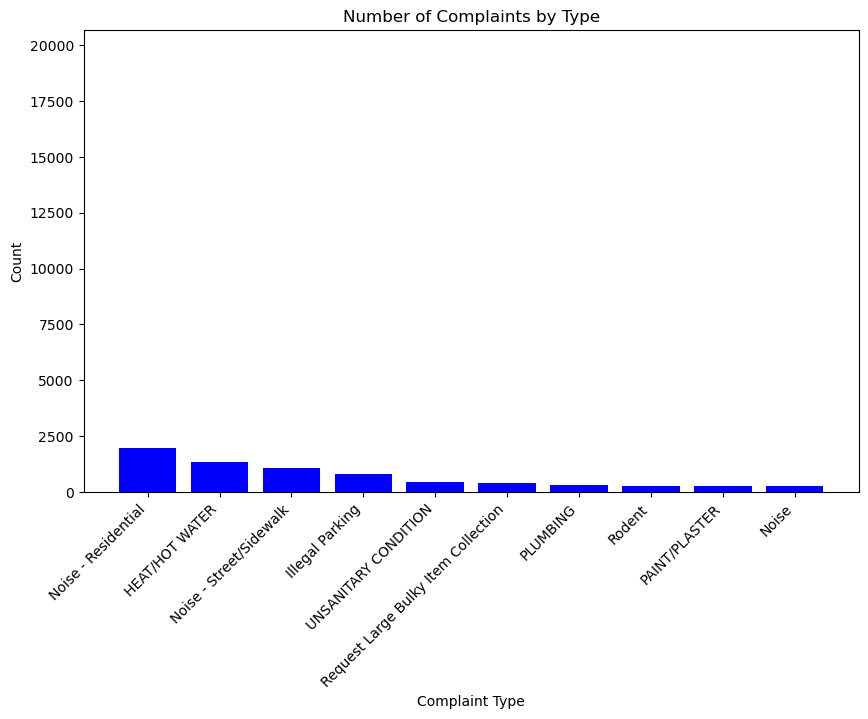

In [211]:
# Use animated bar plot to visualize the data.
visualization_2()

## Visualization 3

Here we use scatter plots because they show the relationship between variables. The general shape of each scatter plot provides useful insights into the relationship between two variables. By comparing the shape of the two plots, we can see the difference between the two relationships.

In [205]:
# Define the SQL query
query_visual_3_tree = """
SELECT rents.zipcode AS zipcode, AVG(rents.rent) AS average_rent, COUNT(*) AS trees_count
FROM rents
JOIN trees ON rents.zipcode =  trees.zipcode
WHERE rents.date BETWEEN '2015-01-01' AND '2023-10-01'
GROUP BY rents.zipcode
ORDER BY average_rent DESC
"""

# Get the tree data
df_visual_3_tree = get_data(query_visual_3_tree)

In [212]:
# Display the first 5 rows in the trees' dataframe
df_visual_3_tree.head()

,zipcode,average_rent,trees_count
0,10282,7029.339152,5520
1,10007,6484.824436,27378
2,10013,4819.141683,118860
3,10069,4615.526230,6160
4,10001,4094.657754,89250


In [206]:
# Define the SQL query
query_visual_3_complaints = """
SELECT rents.zipcode AS zipcode, AVG(rents.rent) AS average_rent, COUNT(*) as complaints_count
FROM rents
JOIN complaints ON rents.zipcode = complaints.zipcode
WHERE complaints.date BETWEEN '2015-01-01' AND '2023-10-01' AND rents.date BETWEEN '2015-01-01' AND '2023-10-01'
GROUP BY rents.zipcode
ORDER BY average_rent DESC
"""

# Get the complaint data
df_visual_3_complaints = get_data(query_visual_3_complaints)

In [213]:
# Display the first 5 rows in the complaints' dataframe
df_visual_3_complaints.head()

,zipcode,average_rent,complaints_count
0,10282,7029.339152,112896
1,10007,6484.824436,2547126
2,10162,4968.739502,1524
3,10013,4819.141683,10259445
4,10069,4615.526230,215600


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def visualization_3(df_3_tree: pd.DataFrame = df_visual_3_tree, df_3_complaints: pd.DataFrame = df_visual_3_complaints) -> None:
    """
    Visualize the relationship between average rent, number of trees, and number of complaints by zipcode.

    Arguments:
        df_3_tree (pd.DataFrame): DataFrame containing tree data.
        df_3_complaints (pd.DataFrame): DataFrame containing complaint data.

    Returns:
        None
    """
    # Set subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Add data for ax1
    ax1.scatter(df_3_tree['average_rent'], df_3_tree['trees_count'], color='blue')

    # Set y-axis for ax1
    ax1.set_ylabel('Number of Trees by Zipcode')
    ax1.set_title('Rent VS Number of Trees by Zipcode')
    ax1.grid(True)  # add grid lines for ax1

    # Add data for ax2
    ax2.scatter(df_3_complaints['average_rent'], df_3_complaints['complaints_count'], color='red')

    # Set y-axis for ax2
    ax2.set_ylabel('Number of Complaints by Zipcode')

    # Set x-axis for both subplots
    ax2.set_xlabel('Average Rent')
    ax2.set_title('Rent VS Number of Complaints by Zipcode')
    ax2.grid(True)  # add grid lines for ax2

    # Display the plot
    plt.show()

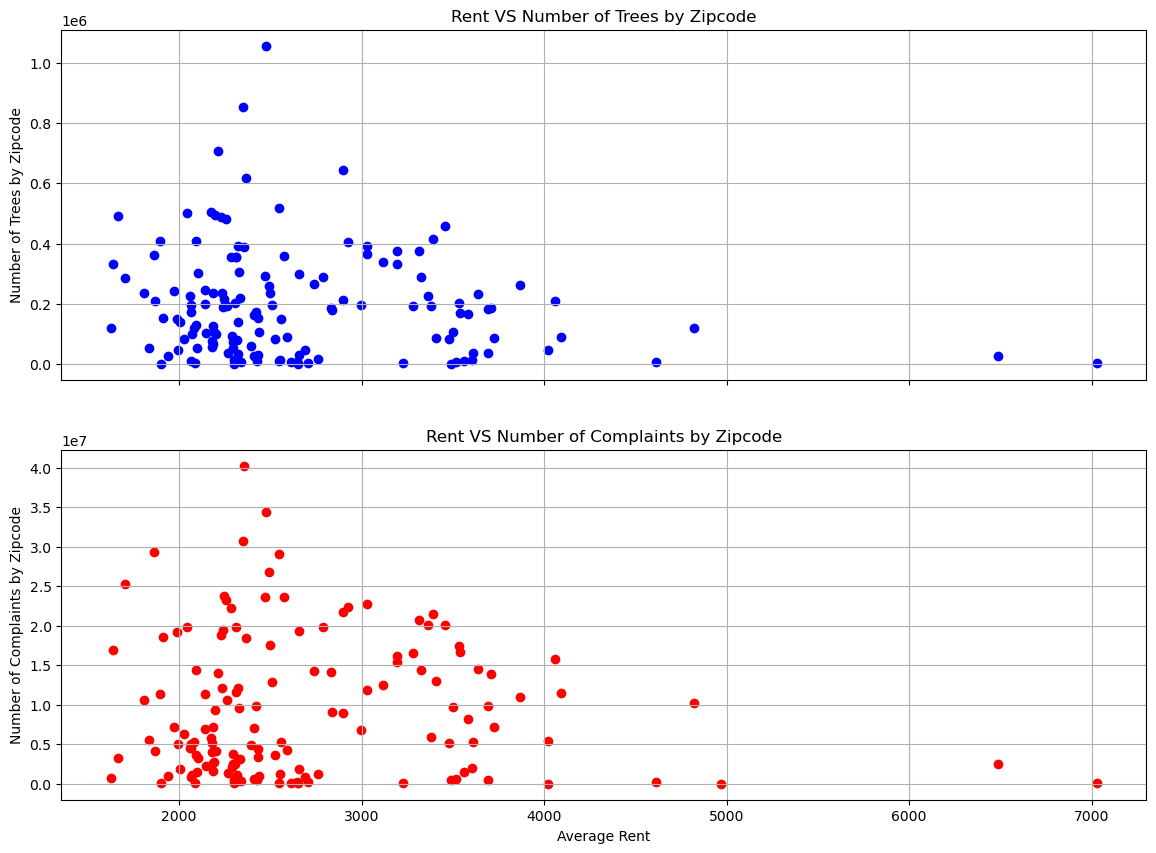

In [215]:
# Use animated bar plot to visualize the data.
visualization_3()

## Visualization 4

With the box plot we can see and compare the ditribution of the complaints with different average rent.

In [216]:
# Define SQL query
query_visual_4 = """
SELECT
  FLOOR(rents.rent / 1000) * 1000 AS rent_bin,
  complaints.zipcode,
  COUNT(DISTINCT complaints.id) AS num_complaints
FROM
  rents
JOIN
  complaints ON rents.zipcode = complaints.zipcode
WHERE
  complaints.date BETWEEN '2022-10-01' AND '2023-10-01'
GROUP BY
  rent_bin, complaints.zipcode
ORDER BY
  rent_bin, complaints.zipcode;
"""

# Get tree data
df_visual_4 = get_data(query_visual_4)

# Display the first 5 rows of the dataframe
df_visual_4.head()

,rent_bin,zipcode,num_complaints
0,1000.0,10032,31974
1,1000.0,10033,23655
2,1000.0,10034,22248
3,1000.0,10037,7939
4,1000.0,10040,19833


In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [217]:
def visualization_4(df: pd.DataFrame = df_visual_4) -> None:
    """
    Visualize the number of 311 complaints by average rent using a boxplot.

    Arguments:
        df (pd.DataFrame): DataFrame containing the data.

    Returns:
        None
    """
    df['rent_bin'] = pd.Categorical(df['rent_bin'])

    # Create a boxplot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='rent_bin', y='num_complaints', data=df)

    # Set labels and title
    plt.xlabel('Average Rent ($1000 bins)')
    plt.ylabel('Number of 311 Complaints')
    plt.title('Boxplot of 311 Complaints by Average Rent in December 2023')

    # Show the plot
    plt.show()

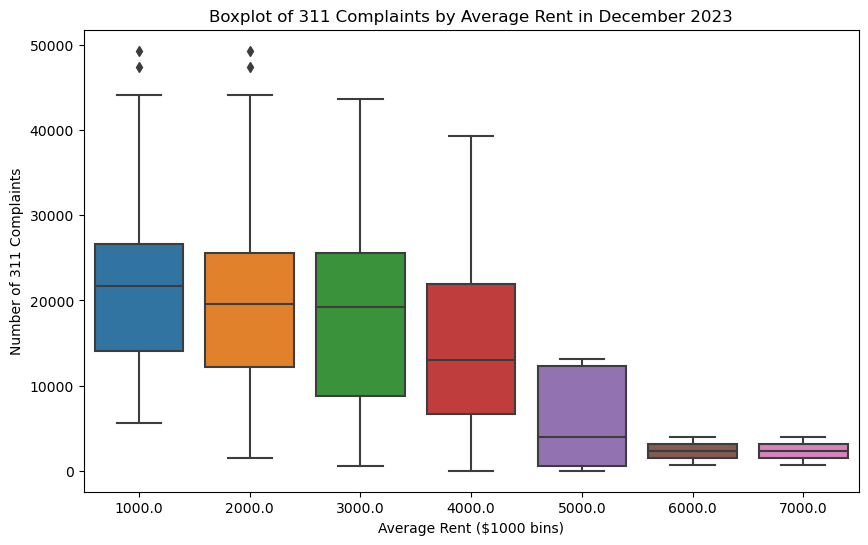

In [218]:
visualization_4()

## Visualization 5

The geospatial plot shows the location of all 311 incidents that happened between January 1st, 2023 and September 30th, 2023 within a 1 kilometer radius of Columbia University.

In [219]:
# Define SQL query
query_visual_5 = f"""
SELECT ST_AsText(location) AS location
FROM complaints 
WHERE ST_DWithin(location::geography, ST_GeomFromText('{target_point}')::geography, 1000) AND date BETWEEN '2023-01-01' AND '2023-10-01'
"""

# Get data
df_visual_5 = get_data(query_visual_5)

# Display the first 5 rows in the dataframe
df_visual_5.head()

,location
0,POINT(-73.95260757339591 40.81166480566812)
1,POINT(-73.95302702883166 40.805972420859355)
2,POINT(-73.95302702883166 40.805972420859355)
3,POINT(-73.95548445294015 40.80427990061059)
4,POINT(-73.95529594898062 40.80528439709217)


In [115]:
from shapely import wkt

In [225]:
def visualization_5(df=df_visual_5) -> None:
    """
    Visualize the reported 311 incidents within 1km of a target point.

    Arguments:
        df (pd.DataFrame): DataFrame with data about reported 311 incidents.

    Returns:
        None
    """

    # Convert textual geometry into geometry objects
    df['geometry'] = df['location'].apply(wkt.loads)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='blue', markersize=5)

    # Plot the target point
    target_point_geom = wkt.loads(target_point)
    target_gdf = gpd.GeoSeries([target_point_geom], crs="EPSG:4326")
    target_gdf.plot(ax=ax, color='red', markersize=100, marker='*')

    # Set axis labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title('Reported 311 Incidents from Jan 1, 2023 to Sep 30, 2023 within 1km of Point')

    # Show the plot
    plt.show()

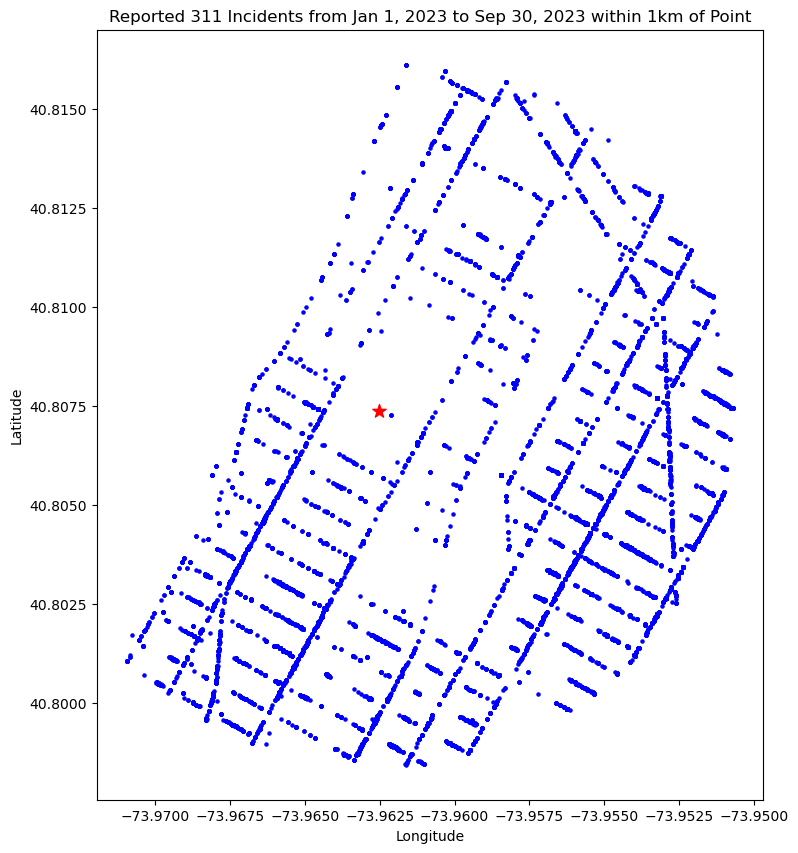

In [221]:
# Show the plot
visualization_5()

## Visualization 6

 The geospatial plot shows the lcoation of all the trees and "New Tree Request" from October 1st, 2018 to September 30th, 2023, so that we can find the spatial relationship between these spots.

In [223]:
# Define SQL query
query_visual_6_request = """
SELECT ST_AsText(location) AS request_location
FROM complaints 
WHERE complaint_type = 'New Tree Request' AND date BETWEEN '2018-10-01' AND '2023-10-01'
"""

# Get tree data
df_visual_6_request = get_data(query_visual_6_request)

# Display the first 5 rows in the dataframe of new tree requests
df_visual_6_request

,request_location
0,POINT(-73.86121923025509 40.851123167367014)
1,POINT(-73.99100425747874 40.76272738277269)
2,POINT(-73.95390843511196 40.64421877479377)
3,POINT(-73.80776061338688 40.720328269590894)
4,POINT(-73.97741559312212 40.638497426185786)
...,...
88481,POINT(-73.94166819194523 40.65173667085024)
88482,POINT(-73.93564859431754 40.697793539960486)
88483,POINT(-73.94810313552304 40.72781929389372)
88484,POINT(-73.96342349761444 40.686607059490356)


In [224]:
# Define SQL query
query_visual_6_tree = """
SELECT ST_AsText(location) AS tree_location
FROM trees 
"""

# Get tree data
df_visual_6_tree = get_data(query_visual_6_tree)

# Display the first 5 rows in the dataframe of trees' location
df_visual_6_tree

,tree_location
0,POINT(-73.84421522 40.72309177)
1,POINT(-73.81867946 40.79411067)
2,POINT(-73.9366077 40.71758074)
3,POINT(-73.93445616 40.71353749)
4,POINT(-73.97597938 40.66677776)
...,...
652162,POINT(-73.98252228 40.75743006)
652163,POINT(-73.98345595 40.75619437)
652164,POINT(-73.91544502 40.70211487)
652165,POINT(-73.91511144 40.70244214)


In [226]:
def visualization_6(df_request=df_visual_6_request, df_tree=df_visual_6_tree) -> None:
    """
    Visualize the geospatial plot of trees and new tree requests.

    Arguments:
        df_request (pd.DataFrame): DataFrame containing the tree request data.
        df_tree (pd.DataFrame): DataFrame containing the tree data.

    Returns:
        None
    """
    df_request['request_location'] = df_request['request_location'].apply(wkt.loads)
    df_tree['tree_location'] = df_tree['tree_location'].apply(wkt.loads)

    # Create GeoDataFrame
    gdf_request = gpd.GeoDataFrame(df_request, geometry='request_location')
    gdf_tree = gpd.GeoDataFrame(df_tree, geometry='tree_location')

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_tree.plot(ax=ax, color='green', markersize=0.001)
    gdf_request.plot(ax=ax, color='red', markersize=0.001)

    # Set axis labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title('Geospatial plot of trees and new tree requests')

    # Show the plot
    plt.show()

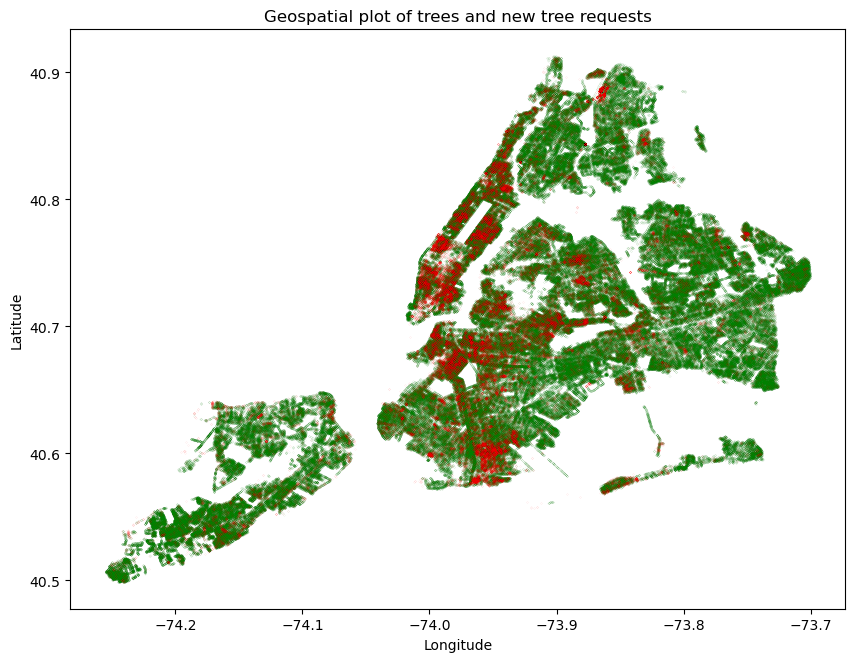

In [227]:
#Display the plot
visualization_6()